# Unexpected Failures Logs

In a different notebook we characterized certain failures as "unexpected". We additionally came up with a simple metric to classify a test run, i.e. a column in TestGrid, as "unexpected". In this notebook we will look at the log data and see what happens in unexpected test failures, and see if these failures are the ones that persist in the unexpected columns.

In [199]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
from google.cloud import storage
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
import itertools
import sys
sys.path.append('../../failure-type-classification')
sys.path.append('./metrics')


from ipynb.fs.defs.failure_type_functions import ( #noqa
    normalize, #noqa
    decode_run_length, #noqa
)

from ipynb.fs.defs.unexpected_test_failures import ( #noqa
    naive_prob_failure, #noqa
    get_grid, #noqa
    preprocess, # noqa
    column_scores, # noqa
    column_score, # noqa
    random_trial, # noqa
    score_grid, # noqa
)

## Get Dataset

We first use data retrieval methods from other notebooks to get the most up-to-date data.

In [4]:
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-informing?id=dashboard-group-bar"
)

In [5]:
html = BeautifulSoup(response.content)
testgrid_script = html.findAll("script")[3]
testgrid_script = testgrid_script.text.split()[5].split(",")
dashboard_names = [x.split(":")[1] for x in testgrid_script if "name" in x]
dashboard_names = [d[1: -1] for d in dashboard_names]
dashboard_names

['redhat-assisted-installer',
 'redhat-hypershift',
 'redhat-openshift-informing',
 'redhat-openshift-ocp-release-3.11-informing',
 'redhat-openshift-ocp-release-4.1-blocking',
 'redhat-openshift-ocp-release-4.1-informing',
 'redhat-openshift-ocp-release-4.10-blocking',
 'redhat-openshift-ocp-release-4.10-broken',
 'redhat-openshift-ocp-release-4.10-informing',
 'redhat-openshift-ocp-release-4.2-blocking',
 'redhat-openshift-ocp-release-4.2-informing',
 'redhat-openshift-ocp-release-4.3-blocking',
 'redhat-openshift-ocp-release-4.3-informing',
 'redhat-openshift-ocp-release-4.4-blocking',
 'redhat-openshift-ocp-release-4.4-broken',
 'redhat-openshift-ocp-release-4.4-informing',
 'redhat-openshift-ocp-release-4.5-blocking',
 'redhat-openshift-ocp-release-4.5-broken',
 'redhat-openshift-ocp-release-4.5-informing',
 'redhat-openshift-ocp-release-4.6-blocking',
 'redhat-openshift-ocp-release-4.6-informing',
 'redhat-openshift-ocp-release-4.7-blocking',
 'redhat-openshift-ocp-release-4.7-in

In [6]:
data_dict = {}
for d in dashboard_names:
    print(d)
    response = requests.get(f"https://testgrid.k8s.io/{d}/summary")
    data = response.json()
    ocp42 = pd.DataFrame(data)
    jobs = ocp42.columns
    dashboard_dict = {}
    for j in jobs:
        response = requests.get(f'https://testgrid.k8s.io/{d}/table?&show-stale-tests=&tab={j}')
        grid = []
        if response.json()["tests"]:
            for x in response.json()["tests"]:
                test = {"name": x["name"], "statuses": x["statuses"]}
                if "graphs" in x.keys():
                    test["graphs"] = x["graphs"]
                else:
                    test["graphs"] = None
                grid.append(test)
            x = np.array(list(pd.DataFrame(grid).statuses.apply(decode_run_length)))
            x = pd.DataFrame(x).apply(lambda x: [normalize(y) for y in x])
            changelists = response.json()['changelists']
            dashboard_dict[j] = {'grid': x, 'timestamps': changelists}
        else:
            continue
    data_dict[d] = dashboard_dict

redhat-assisted-installer
redhat-hypershift
redhat-openshift-informing
redhat-openshift-ocp-release-3.11-informing
redhat-openshift-ocp-release-4.1-blocking
redhat-openshift-ocp-release-4.1-informing
redhat-openshift-ocp-release-4.10-blocking
redhat-openshift-ocp-release-4.10-broken
redhat-openshift-ocp-release-4.10-informing
redhat-openshift-ocp-release-4.2-blocking
redhat-openshift-ocp-release-4.2-informing
redhat-openshift-ocp-release-4.3-blocking
redhat-openshift-ocp-release-4.3-informing
redhat-openshift-ocp-release-4.4-blocking
redhat-openshift-ocp-release-4.4-broken
redhat-openshift-ocp-release-4.4-informing
redhat-openshift-ocp-release-4.5-blocking
redhat-openshift-ocp-release-4.5-broken
redhat-openshift-ocp-release-4.5-informing
redhat-openshift-ocp-release-4.6-blocking
redhat-openshift-ocp-release-4.6-informing
redhat-openshift-ocp-release-4.7-blocking
redhat-openshift-ocp-release-4.7-informing
redhat-openshift-ocp-release-4.8-blocking
redhat-openshift-ocp-release-4.8-broken


In [7]:
response = requests.get(
    'https://testgrid.k8s.io/redhat-osd/table?&show-stale-tests=&tab=osde2e-prod-gcp-e2e-upgrade-to-next-z')

In [8]:
grid = []
for x in response.json()["tests"]:
    test = {"name": x["name"], "statuses": x["statuses"]}
    if "graphs" in x.keys():
        test["graphs"] = x["graphs"]
    else:
        test["graphs"] = None
    grid.append(test)

In [9]:
def get_random_dashboard():
    dashboard = np.random.choice(list(data_dict.keys()))
    job = np.random.choice(list(data_dict[dashboard].keys()))
    return dashboard, job

In [12]:
# taken from data-sources/gcsweb-ci/build-logs/build_log_EDA.ipynb

client = storage.client.Client.create_anonymous_client()
bucket = client.bucket("origin-ci-test")

In [13]:
def prow_url_for(job, build_id):
    return f"https://prow.ci.openshift.org/view/gcs/origin-ci-test/logs/{job}/{build_id}"


def build_log_url_for(job, build_id):
    """Returns a public URL to download a build's build-log.txt"""
    blob = bucket.get_blob(f"logs/{job}/{build_id}/build-log.txt")
    return blob.public_url


def testgrid_url(dash, job):
    return f"https://testgrid.k8s.io/{dash}#{job}"

In [26]:
dash, job = get_random_dashboard()

print(dash)
print(job)

redhat-openshift-okd-release-4.7-blocking
periodic-ci-openshift-release-master-okd-4.7-e2e-aws


In [27]:
grid = data_dict[dash][job]['grid']
grid.head(5)

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,0,1.0,-1.0,-1.0,...,-1.0,1.0,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,NaN,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,NaN,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Visualizations

We visualize the grid a little bit. The yellow represents a failure when the chance of failure is < 5%.

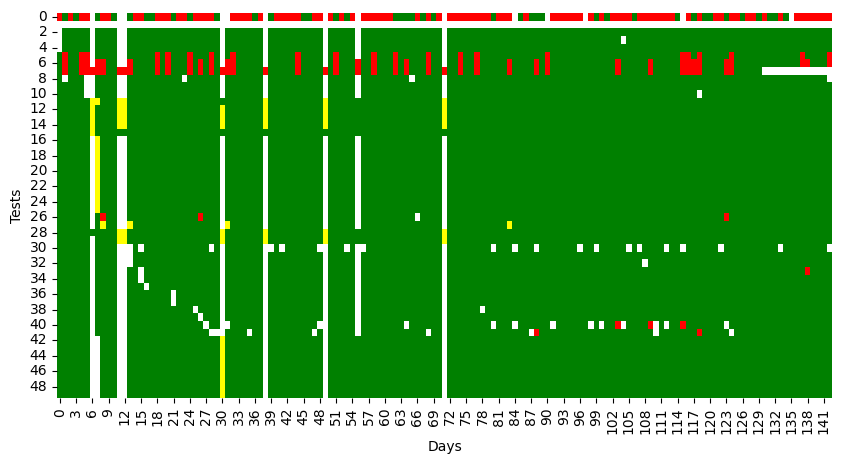

In [30]:
get_grid(grid)

In [28]:
# check to see if testgrid data more or less matches

testgrid_url(dash, job)

'https://testgrid.k8s.io/redhat-openshift-okd-release-4.7-blocking#periodic-ci-openshift-release-master-okd-4.7-e2e-aws'

In [29]:
scores = score_grid(grid)

Now we look at the unexpectness scores. Anything with a score > .9 or so we can call highly unexpected.

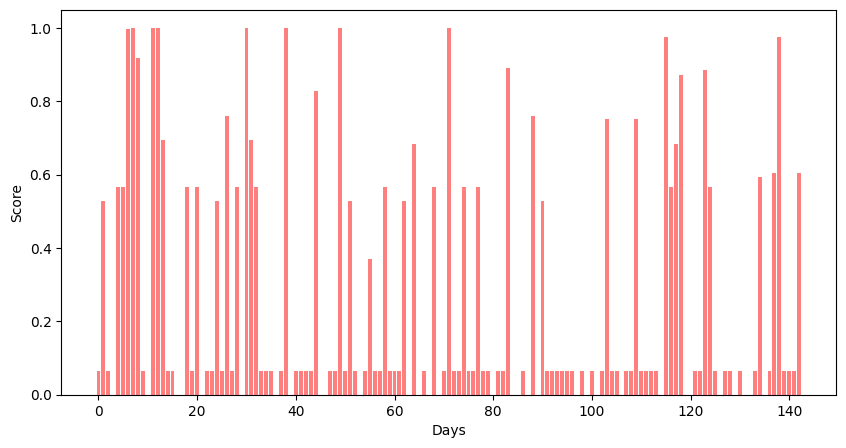

In [31]:
plt.figure(figsize=(10, 5))
plt.bar(x = grid.columns, height = scores, color = 'r', alpha = 0.5)
plt.ylabel("Score")
plt.xlabel("Days")
plt.show()

In [32]:
tstamps = data_dict[dash][job]['timestamps']

Now we extract all the lines of the logs of the runs. We then filter out the logs so only lines that say "error" appear.

In [33]:
# look at only the errors
error_lines = []
log_lines = []

for tstamp in tstamps:
    r = requests.get(build_log_url_for(job, tstamp))
    line_list = r.text.split('\n')
    log_lines.append(line_list)
    line_list = [line for line in line_list if 'error' in line.lower()]
    error_lines.append(line_list)

We take a look at the number of error lines, in red, and the score in green.

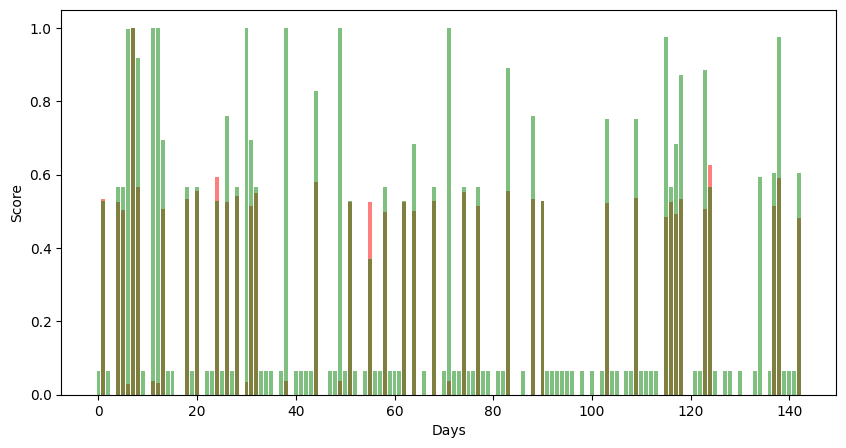

In [35]:
line_lens = np.array([len(line) for line in error_lines])
line_lens = (line_lens - min(line_lens))/max(line_lens)

plt.figure(figsize=(10, 5))
plt.bar(x = grid.columns, height = line_lens, color = 'r', alpha = 0.5)
plt.bar(x = grid.columns, height = scores, color = 'g', alpha = 0.5)
plt.ylabel("Score")
plt.xlabel("Days")
plt.show()

At first when doing this analysis I started to think the "unexpectedness" metric was useless due to the very heavy overlap between the unexpectedness score and the number of error lines. However, this changed when I saw this graph. The red is the number of error lines in a log (min-max scaled), and the green is the scores themselves. We see that there isn't any perfect correlation here. Thus, there is something more interesting to uncover.

We wish to compare the logs of highly unexpected test runs. The outputs are messy, and we figure a decent naive method for now is just to compare their letters count.  We turn every log into a 26 dimensional vector of the letters that it contains.

In [154]:
letters = [chr(char) for char in range(ord('a'), ord('z') + 1)]

In [155]:
def get_letters_vector(error_line):
    c = Counter(error_line)
    return np.array([c[letter] for letter in letters])

In [59]:
# we purposefully choose two runs that we see have a high number of error log lines

list1, list2 = error_lines[7], error_lines[138]

In [60]:
# the goal is to compare the errors and see how many overlapping characters they have

In [61]:
len(list1)

1779

In [62]:
len(list2)

1051

In [63]:
list1_counts = [get_letters_vector(line) for line in list1]
list2_counts = [get_letters_vector(line) for line in list2]

Below we show distribution of the number of letters in both lists.

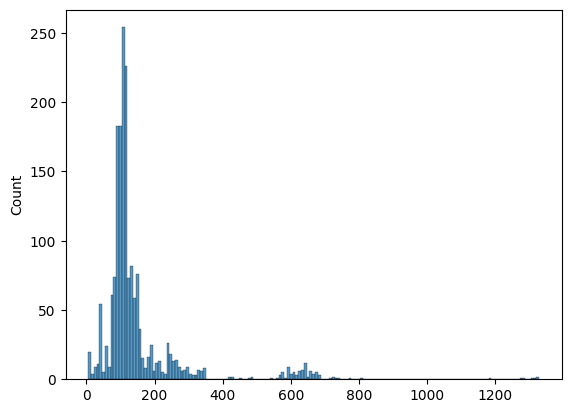

In [72]:
sns.histplot([sum(line) for line in list1_counts])
plt.show()

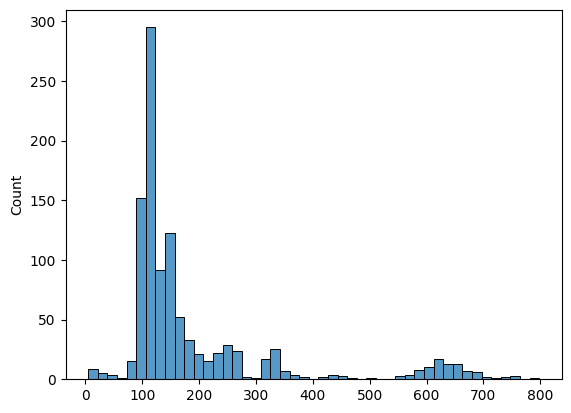

In [71]:
sns.histplot([sum(line) for line in list2_counts])
plt.show()

It's interesting to see that the distributions are shaped about the same here. Maybe expected due to the large sample sizes.

We define our distance metric between two logs as the absolute distance between their character vectors divided by the sum of the lengths of their character vectors.

In [156]:
def mean_distance(item1, item2):
    return sum([abs(i1 - i2) for i1, i2 in zip(item1, item2)])/(sum(item1)+sum(item2))

In [140]:
dists = [[mean_distance(a, b) for b in list2_counts] for a in list1_counts]

In [143]:
dists = np.array(dists)

In [145]:
dists.shape

(1779, 1051)

We visualize the distributions of the minimum distance from a log in the other list, for both the first list of logs and the second list of logs.

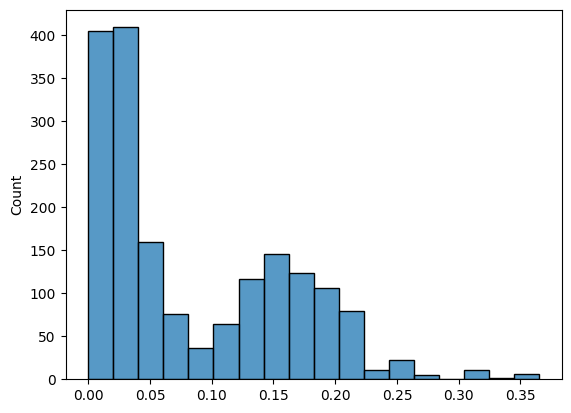

In [152]:
# rows: list1
# columns: list2

sns.histplot(np.apply_along_axis(min, axis = 1, arr = dists))
plt.show()

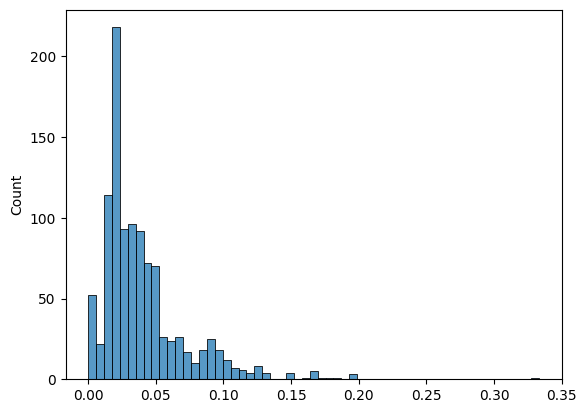

In [153]:
sns.histplot(np.apply_along_axis(min, axis = 0, arr = dists))
plt.show()

In [165]:
indxs1 = np.apply_along_axis(min, axis = 1, arr = dists)
indxs2 = np.apply_along_axis(min, axis = 0, arr = dists)

In [166]:
weird1 = np.array(list1)[indxs1 > 0.1]
weird2 = np.array(list2)[indxs2 > 0.1]

Now we find the error messages that were not close to an error message in the other list. For both lists, we print ten of these random error messages.

In [170]:
for i in np.random.choice(weird1, size = 10):
    print(i)

print('- - - - - - - -')

for i in np.random.choice(weird2, size = 10):
    print(i)

Nov 27 20:58:10.022: INFO: Error running /usr/bin/oc --namespace=e2e-test-new-app-nxz9v --kubeconfig=/tmp/configfile159375889 new-app https://github.com/sclorg/nodejs-ex --image-stream=nodejs:latest:
Error from server (BadRequest): previous terminated container "pruner" in pod "revision-pruner-6-ip-10-0-231-106.us-west-1.compute.internal" not found
Error from server (BadRequest): previous terminated container "node-ca" in pod "node-ca-vc8t5" not found
error: shallow cloning repository "https://github.com/sclorg/nodejs-ex" to "/tmp/gen866413345" failed: Cloning into '/tmp/gen866413345'...
Error from server (BadRequest): previous terminated container "network-metrics-daemon" in pod "network-metrics-daemon-gt74f" not found
Error from server (NotFound): apiservers.config.openshift.io "dns.config.openshift.io" not found
Error from server (BadRequest): previous terminated container "installer" in pod "installer-6-ip-10-0-231-106.us-west-1.compute.internal" not found
Error from server (BadReq

We can actually easily see here a prevailing problem in the first test run that doesn't appear in the second run: there's a bunch of containers that aren't found. This is exactly the type of thing that we would like to capture. We also find that looking for the word "error" is not very prudent, as most of the errors in the second list don't seem like important errors, but rather warnings (but we don't know much about this to be honest)

This is still highly exploratory and the methods used here are not necessarily generalizable. What we need to do is compare all the test runs to one another, maybe by some means of clustering logs. Hopefully any test runs that have similar problems to one another would show that they have many items in the same cluster.

We first choose all the runs that have an unexpectedness score > 0.95 and then collect the log data for them.

In [182]:
unexpected_runs = np.array(scores) > .95
unexp_tstamps = np.array(tstamps)[unexpected_runs]

In [183]:
# look at only the errors
error_lines = []
log_lines = []

for tstamp in unexp_tstamps:
    r = requests.get(build_log_url_for(job, tstamp))
    line_list = r.text.split('\n')
    log_lines.append(line_list)
    line_list = [line for line in line_list if 'error' in line.lower()]
    error_lines.append(line_list)

In [185]:
# print number of lines
print([len(log_line) for log_line in log_lines])
print([len(error_line) for error_line in error_lines])

[196, 55552, 265, 301, 324, 265, 265, 266, 51730, 43755]
[51, 1779, 68, 55, 61, 68, 68, 68, 864, 1051]


In [186]:
all_letters = [[get_letters_vector(e) for e in error_line] for error_line in error_lines]

We plot the log data on a TSNE graph, with the color symbolizing which run it comes from.

In [244]:
run_class = []
for i, length in enumerate([len(error_line) for error_line in error_lines]):
    run_class += [str(i)]*length

In [203]:
letters_tg = list(itertools.chain.from_iterable(all_letters))
tsne = TSNE()
letters_tg_out = tsne.fit_transform(letters_tg)

/opt/app-root/lib64/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/app-root/lib64/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


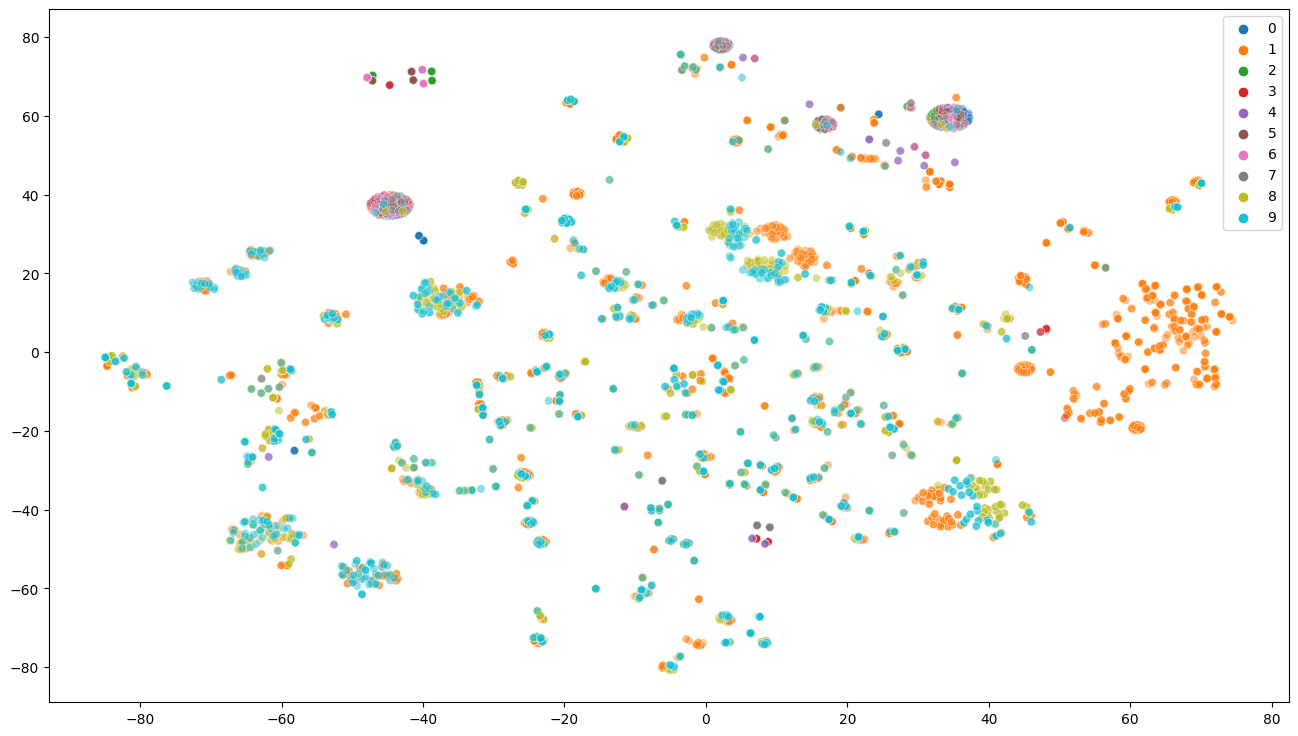

In [248]:
plt.figure(figsize = (16, 9))
ax = sns.scatterplot(x = letters_tg_out[:,0], y = letters_tg_out[:,1], hue = run_class, alpha = 0.5)
plt.show()

This is an interesting plot; we see some clusters fairly randomly distributed across the board. Some clusters are so close together that we can assume that those are probably the same error mesasge. The blue, orange, and phlegm green dominate the dataset, but nothing really sticks out about the blue or green that separates them from one another or the orange. We see that blue can pop up in rare places where there is only orange or orange and phlegm green. Then of course, there is one thing that we definitely can not ignore: the large cluster of only orange on the right. If I had to guess, those are the "pod not found" error messages that stuck out before.

We would like to come up with an algorithmic way correlate the phlegm green, blue, and orange. We would also like to note the large orange cluster somehow in such an algorithm. So maybe a final output would be: strong relation with green, blue, slightly less so with orange, with this extraneous group: (insert cluster here somehow).